# Multivariate Rolling Regression Model for National Retail Gas Log Return

### Table of Contents
* Set-up
* Differentiation
* Predictors
    * Correlation with Predictors
    * Select Predictors by LARS Path
    * Correlation betweeen Predictors
    * Selected Predictors
* Rolling Regression
    * Change of Regression Coefficients over time
* Test in Training Period
  + Metric 1: Correlation of Predicted and Actual Log Return
  + Outlier: Hurrican Katrina
  + Metric 2: Precision, Recall, and Accuracy of Predicting Price Move Directions
* Test in Cross-Validation Period
  + Metric 1: Correlation of Predicted and Actual Log Return
  + Metric 2: Precision, Recall, and Accuracy of Predicting Price Move Directions

## Set-up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import LinearRegression, LassoLars, lars_path, lasso_path
from sklearn.preprocessing import normalize
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

/Users/ChingYunH/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def custom_read_csv(filename):
    df = pd.read_csv(filename)
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index('date')

Read retail gas prices from csv.

In [3]:
# note that all prices are released on Monday, dayofweek = 0
national_price = custom_read_csv('national.csv').dropna()
state_price = custom_read_csv('state.csv').dropna()
state_price = state_price.drop('Unnamed: 10', axis=1).dropna()
city_price = custom_read_csv('city.csv').dropna()
price = pd.concat([national_price, state_price, city_price], axis=1)

The training period is 1992 - 2010. Save 2011 - 2016 for cross-validation.

In [4]:
trainingdates = np.intersect1d(price.index, pd.date_range('1992-01-01','2010-12-31'))

## Differentiation

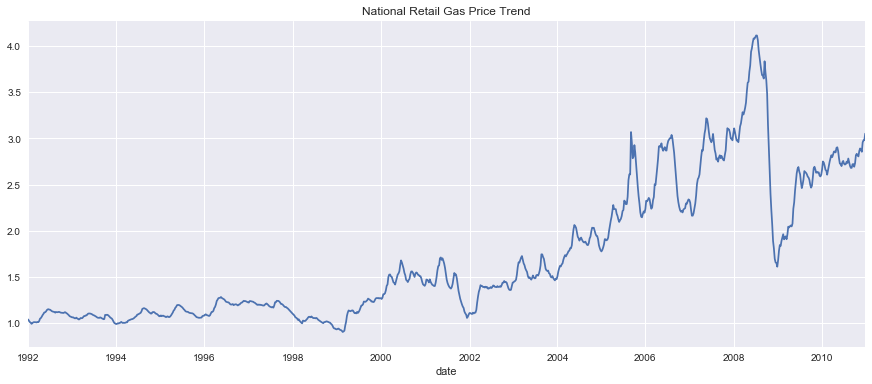

In [5]:
price.national.loc[trainingdates].plot(figsize=(15,6), title='National Retail Gas Price Trend')
plt.show()

National retail gas price is not a stationary time series, especially obvious after 1999. Augmented Dicken Fuller test confirms the intuition - it fails to reject the non-stationary null hypothesis.

In [6]:
pvalue = adfuller(price.national[trainingdates])[1]
pvalue

0.68376529942817021

Differentiate the series. (Take approximate log returns.)

In [7]:
logreturn = (price.national - price.national.shift(1)) / price.national.shift(1)
logreturn = logreturn.rename('logreturn')

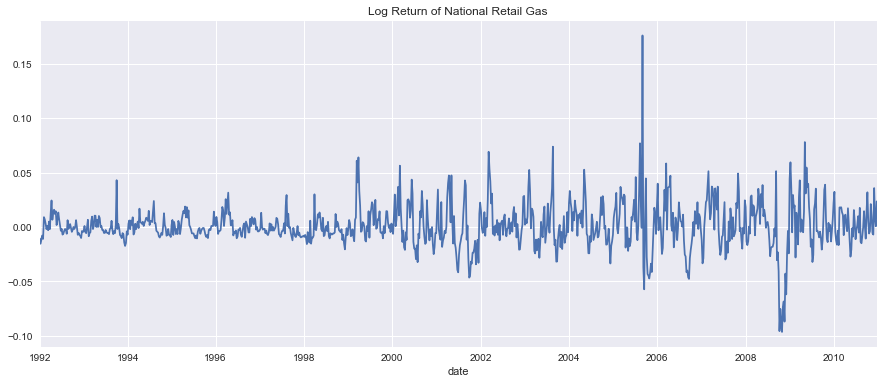

In [8]:
logreturn[trainingdates].plot(figsize=(15,6), title='Log Return of National Retail Gas')
plt.show()

ADF test says the differentiated series is stationary, so we will build the regression model on log return.

In [9]:
pvalue = adfuller(logreturn[trainingdates].dropna())[1]
pvalue

5.1087292642223889e-12

## Predictors

Read data for predictors and take log returns. The predictors are:

* Spot prices of WTI, Brent, gasoline (NY), gasoline (Gulf Coast)
* Stocks of crude oil and gasoline
* Supply for crude oil and gasoline

All predictors are weekly time series.

In [10]:
spot = custom_read_csv('spot.csv').drop('Unnamed: 3', axis=1).dropna()
gasspot = custom_read_csv('gasspot.csv').drop('Unnamed: 3', axis=1).dropna()
supply = custom_read_csv('productsupplied.csv').dropna()
stocks = custom_read_csv('stocks.csv').dropna()
predictors_raw = pd.concat([spot, gasspot, supply, stocks], axis=1)

# take log return for all predictors
predictors = (predictors_raw - predictors_raw.shift(1)) / predictors_raw.shift(1)

# the predictors are relaesed on Friday, add 3 days to align
predictors.index = predictors.index + pd.DateOffset(days=3)

### Correlation with predictors

In [11]:
correls = pd.concat([logreturn, predictors], axis=1).rolling(window=52*2).corr()
correls = correls.loc[(slice(None), 'logreturn'),:].dropna().drop('logreturn', axis=1)
correls.index = correls.index.droplevel(level=1)

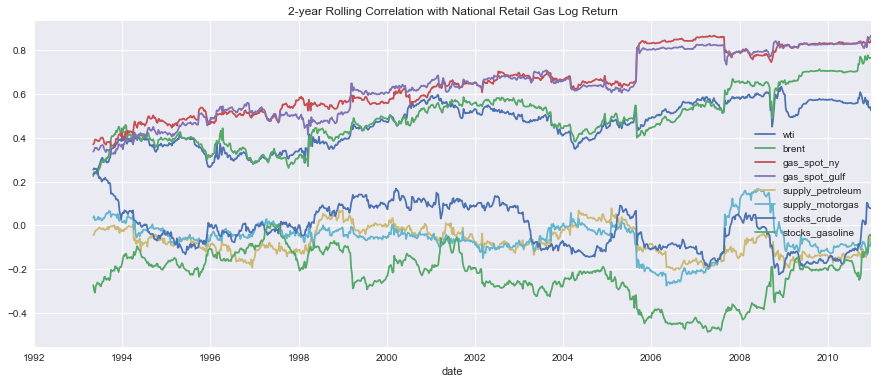

In [12]:
correls.loc[trainingdates].plot(
    figsize=(15,6), title='2-year Rolling Correlation with National Retail Gas Log Return')
plt.show()

* Log returns of gasoline spot price are the most correlated. 
* Log return of gasoline stocks is the most negatively correlated.

There are a lot of predictors being considered, and they are highly correlated to each other.

### Select Predictors by LARS Path

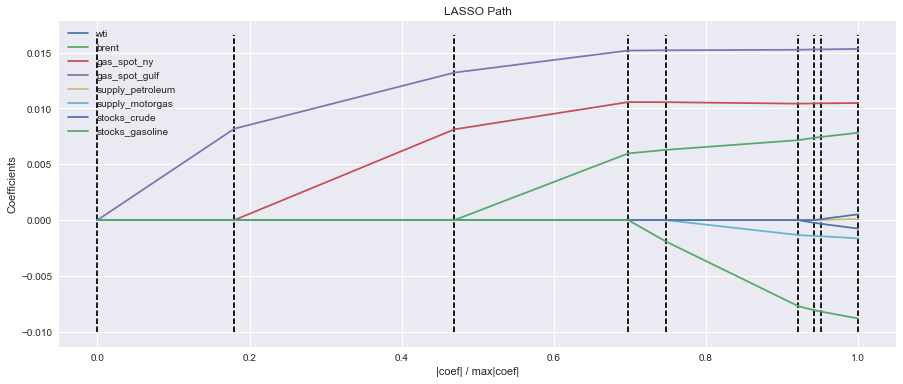

In [13]:
y = logreturn.loc[trainingdates].values
X = predictors.loc[trainingdates].values
alphas, _, coefs = lars_path(normalize(X), y, method='lasso', verbose=False)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(15,6))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(predictors.columns)
plt.show()

According to LARS, select the following predictors:

* Log return of Gulf Coast Gasoline Spot Price
* Log return of NY Gasoline Spot Price
* Log return of Gasoline Stocks

In [14]:
X = predictors[['gas_spot_gulf', 'gas_spot_ny', 'stocks_gasoline']].loc[trainingdates].values
y = logreturn.loc[trainingdates].values

### Correlation between Predictors

In [15]:
np.corrcoef(X, rowvar=False)

array([[ 1.        ,  0.88852167, -0.21580561],
       [ 0.88852167,  1.        , -0.21693077],
       [-0.21580561, -0.21693077,  1.        ]])

As expected, Gulf Coast spot price and NY spot price are highly correlated. So we only include one of them in the regression.
Among the two, we select Gulf Caost gasoline spot price based on the LARS path.

### Selected predictors:
#### 1) Log return of Gulf Coast Gasoline Spot Price
#### 2) Log return of NY Gasoline Spot Price

In [16]:
selected_predictors = predictors[['gas_spot_gulf', 'stocks_gasoline']]

Check if the two chosen predictors are stationary. ADF says they both are stationary.

In [17]:
for x in selected_predictors.columns:
    print 'ADF test p-value on %s:' % x, adfuller(selected_predictors[x].dropna())[1]

ADF test p-value on gas_spot_gulf: 1.03997962244e-27
ADF test p-value on stocks_gasoline: 1.63983937372e-25


## Rolling Regression

Instead of doing one regression on the whole training set, we choose to do rolling regression (exponentially weighted with halflife = 5 years). 

The training period is very long (18 years), so likely the correlation changes over time. Rolling regression better captures the changing relations.

In [18]:
def regress(predictor, response, start, end, halflife, returnr2=False, outlier_cap=2):
    '''
        helper function to run regression
        predictor: dataframe of predictors
        response: series of response
        start: start date
        end: end date
        halflife: halflife to weight regression exponentially
    '''
    y = response[start:end].values
    X = predictor[start:end].values
    
    # cap both y and X at 2 standard deviations to avoid heavy influence of outliers
    y = np.clip(y, -outlier_cap * np.std(y), outlier_cap * np.std(y))
    X = np.clip(X, -outlier_cap * np.std(X, axis=0), outlier_cap * np.std(X, axis=0))
    
    assert X.shape[0] == y.shape[0], "predictor and response are not the same length"
    
    w = np.ones(y.shape)
    decay = 2.0 ** (-1.0/halflife)
    for i in range(len(w)-2, -1, -1):
        w[i] = w[i+1] * decay
    
    reg = LinearRegression(normalize=True)
    reg.fit(X, y, sample_weight=w)
    if returnr2:
        return (reg, reg.score(X,y))
    return reg

Perform rolling regression on the training period. 

Use 5 years as halflife. 

(According to backtesting in the training period, 5 years as halflife works better than shorter halflife.)

In [19]:
# Rolling regression

regression_window = 52 * 5
regression_halflife = 52 * 5

reg = np.empty(len(trainingdates), dtype=object)
for t in range(regression_window, len(trainingdates)):
    reg[t] = regress(selected_predictors, logreturn, 
                     trainingdates[t-regression_window], trainingdates[t], 
                     regression_halflife)
regobj = pd.Series(reg[regression_window:], index=trainingdates[regression_window:], name='regress_object')

/Users/ChingYunH/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


### Change of Regression Coefficients over time

As expected, the regressed coefficient does change over time. The coefficient to spot price is more stable than to stocks.

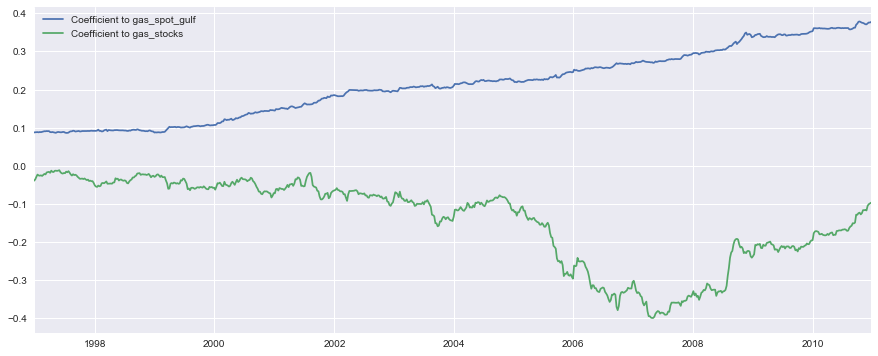

In [20]:
plt.figure(figsize=(15,6))
regobj.map(lambda x: x.coef_[0]).plot(label='Coefficient to gas_spot_gulf')
regobj.map(lambda x: x.coef_[1]).plot(label='Coefficient to gas_stocks')
plt.legend()
plt.show()

## Test in Training Period

Since this is a predictive model, we test it by making predictions using only historical data.
    
Every week, use training data from 5 years ago up to the past week to get regression coefficients. Then, predict according to the most recent predictor data.

In [21]:
df = pd.concat([pd.Series(trainingdates[regression_window:], index=regobj.index, name='date'), 
                regobj], axis=1).shift(1).dropna()
prediction = df.apply(lambda x: x.regress_object.predict(selected_predictors.loc[x.date].values.reshape(1,-1)), 
                      axis=1)['date']
prediction = prediction.rename('predicted').rename_axis('date')

### Metric 1: Correlation between predicted and acutal log returns

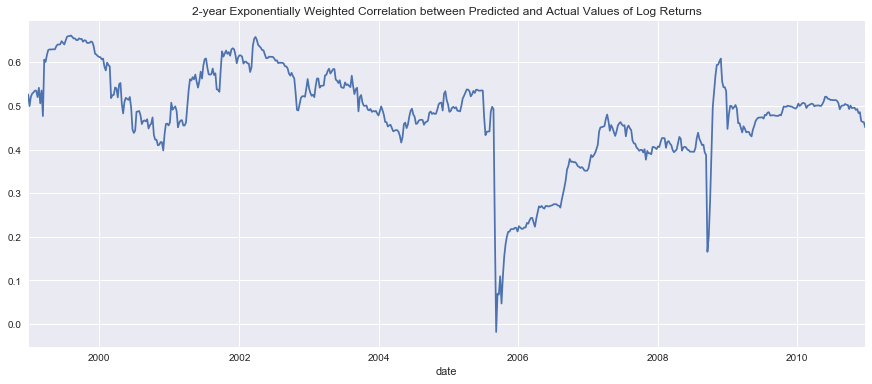

In [22]:
corr = pd.concat([logreturn, prediction], axis=1).ewm(span=52 * 2).corr().dropna()
corr = corr.unstack()['logreturn']['predicted']
corr[trainingdates[regression_window+52*2:]].plot(
    figsize=(15,6), title='2-year Exponentially Weighted Correlation between Predicted and Actual Values of Log Returns')
plt.show()

### Outlier: Hurrican Katrina

What caused the drop in correlation in 2005? 

First find the dates of the big drop and the big jump, and observe the log return series.

In [23]:
corr[abs(corr - corr.shift(1)) > 0.1]

date
1997-01-20   -0.593946
1997-01-27    0.325620
1997-02-03    0.222917
1997-02-17    0.383747
1997-03-31    0.312470
1997-05-26    0.379136
1997-08-04    0.345296
1997-08-11    0.544110
1999-03-22    0.606223
2005-09-05    0.219712
2005-09-12   -0.018267
2008-09-22    0.165611
2008-10-13    0.392694
2008-10-20    0.497783
Name: predicted, dtype: float64

The price suddenly jumps up 17.6% the week of 2005-09-05. There's also a 42% big jump in gasoline spot price the same week.
That was Hurrican Katrina. The US lost one-fifth of its domestic petroleum output.

In [24]:
pd.concat([logreturn['2005-08-15':'2005-10-01'].rename('national_retail_gas'),
           selected_predictors['2005-08-15':'2005-10-01']], axis=1).round(3)

,national_retail_gas,gas_spot_gulf,stocks_gasoline
date,,,
2005-08-15,0.077,0.093,-0.024
2005-08-22,0.024,0.023,-0.016
2005-08-29,-0.001,-0.045,-0.003
2005-09-05,0.176,0.423,-0.022
2005-09-12,-0.037,-0.158,0.010
2005-09-19,-0.057,-0.158,0.018
2005-09-26,0.006,0.216,0.023


### Metric 2: Precision, Recall, and Accuracy of Predicted Price Move Directions

#### Precision

In [25]:
1.0 * np.logical_and(logreturn[trainingdates] > 0, prediction[trainingdates] > 0).sum() / \
    (prediction[trainingdates] > 0).sum()

0.618798955613577

#### Recall

In [26]:
1.0 * np.logical_and(logreturn[trainingdates] > 0, prediction[trainingdates] > 0).sum() / \
    (logreturn[trainingdates] > 0).sum()

0.5254988913525499

#### Accuracy

In [27]:
1.0 * (np.sign(logreturn[trainingdates]) == np.sign(prediction[trainingdates])).sum() / len(trainingdates)

0.48335015136226034

This is perhaps not so much better than random guessing.

Car owners care more about the directional moves rather than the numerical log return value. 

For this purpose, perhaps a classification model would do better than time series prediction.

## Test in Cross-Validation Period

In [28]:
cvdates = np.intersect1d(price.index, pd.date_range('2011-01-01','2016-12-31'))

In [29]:
# Rolling regression

regression_window = 52 * 5
regression_halflife = 52 * 5

dates = np.union1d(trainingdates, cvdates)

reg = np.empty(len(dates), dtype=object)
for t in range(regression_window, len(dates)):
    reg[t] = regress(selected_predictors, logreturn, 
                     dates[t-regression_window], dates[t], 
                     regression_halflife)
regobj = pd.Series(reg[regression_window:], index=dates[regression_window:], name='regress_object')

In [30]:
df = pd.concat([pd.Series(dates[regression_window:], index=regobj.index, name='date'), 
                regobj], axis=1).shift(1).dropna()
prediction = df.apply(lambda x: x.regress_object.predict(selected_predictors.loc[x.date].values.reshape(1,-1)), 
                      axis=1)['date']
prediction = prediction.rename('predicted').rename_axis('date')

### Metric 1: Correlation between predicted and actual log returns

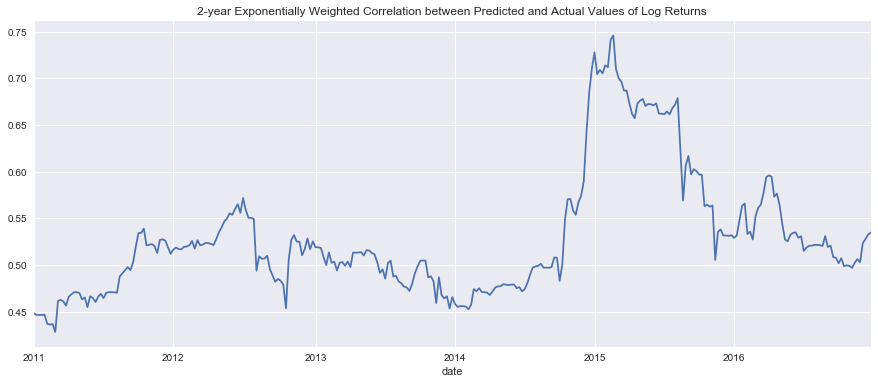

In [31]:
corr = pd.concat([logreturn, prediction], axis=1).ewm(span=52 * 2).corr().dropna()
corr = corr.unstack()['logreturn']['predicted']
corr[cvdates].plot(
    figsize=(15,6), title='2-year Exponentially Weighted Correlation between Predicted and Actual Values of Log Returns')
plt.show()

### Metric 2: Precision and Recall of Predicted Price Move Directions

#### Precision

In [32]:
1.0 * np.logical_and(logreturn[cvdates] > 0, prediction[cvdates] > 0).sum() / \
    (prediction[cvdates] > 0).sum()

0.6666666666666666

#### Recall

In [33]:
1.0 * np.logical_and(logreturn[cvdates] > 0, prediction[cvdates] > 0).sum() / \
    (logreturn[cvdates] > 0).sum()

0.7801418439716312

#### Accuracy

In [34]:
1.0 * (logreturn[cvdates] * prediction[cvdates] > 0).sum() / len(cvdates)

0.7220447284345048

The model works better in cross-validation period than in training period. This means we didn't overfit.